In [1]:
import pandas as pd
pd.options.display.max_columns = 100

In [2]:
muts_df = pd.read_pickle("./data/GYD_df.pkl")
muts_df.shape

(148, 45)

In [4]:
from util.feature import get_feat_d


cond_cnt_d = {"none": 0}
feat_cnt = 0
for _, r in muts_df.iterrows():
    for regdb_id, links in r["operon links"].items():
        feat_d = get_feat_d(RegulonDB_ID=regdb_id, json=r["operons"])
        
        # Getting counts according to links
        feat_cnt += len(links)
        for i in range(0, len(links)):
            if len(feat_d["significantly associated conditions"]) > 0:
                for c in feat_d["significantly associated conditions"]:
                    if c not in cond_cnt_d.keys():
                        cond_cnt_d[c] = 0
                    cond_cnt_d[c] += 1
            else:
                cond_cnt_d["none"] += 1
        
cond_cnt_d

{'none': 63, 'glycerol(2.5)': 87, 'NaCl(0.5g/L) trace elements': 64}

,condition,mutated feature count,proportion
0,none,63.0,0.414474
1,glycerol(2.5),87.0,0.572368
2,NaCl(0.5g/L) trace elements,64.0,0.421053


Text(0.5, 0, 'mutated feature count')

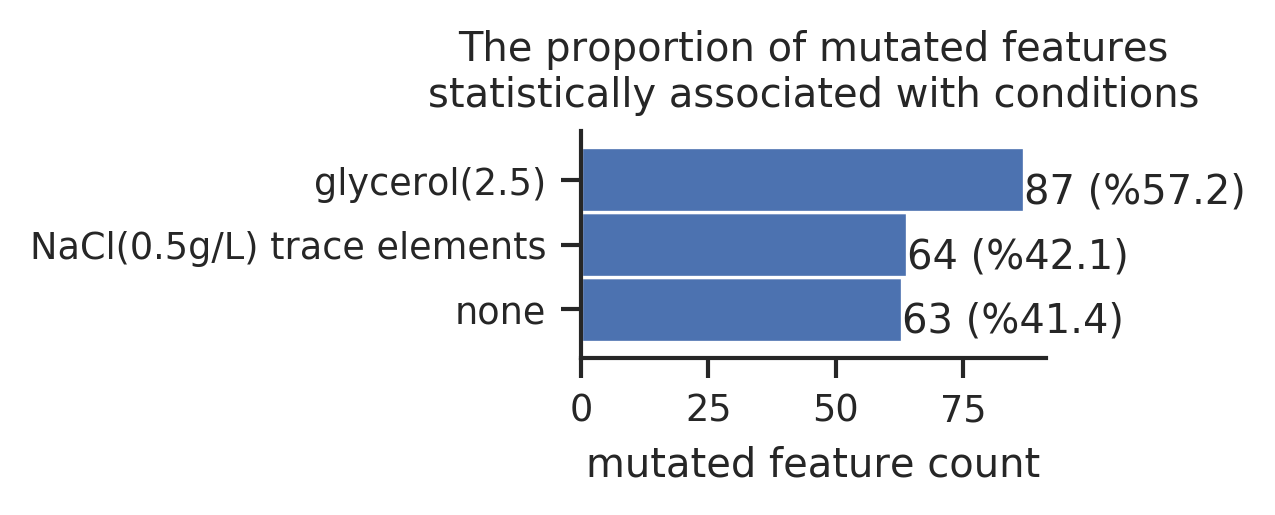

In [5]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.dpi"] = 300
sns.set_context("paper")
sns.set_style("ticks")

cond_cnt_df = pd.DataFrame()
for key, val in cond_cnt_d.items():
    cond_cnt_df = cond_cnt_df.append({"condition": key, "mutated feature count": val, "proportion":val/feat_cnt}, ignore_index=True)
display(cond_cnt_df)

cond_cnt_df = cond_cnt_df.sort_values(by="mutated feature count", ascending=True)

ax = cond_cnt_df.plot.barh(
    y="mutated feature count",
    x="condition",
    color="#4C72B0",
    figsize=(2,1),
    width=1
)

cond_cnt_df = cond_cnt_df.reset_index()  # Resetting index for the below annotations to work
for i, r in cond_cnt_df.iterrows(): 
    s = str(int(r["mutated feature count"])) +' (%{0:.1f})'.format(r["proportion"] * 100)
    ax.text(r["mutated feature count"], i-0.35,  s)
sns.despine(ax=ax, top=True, right=True)
ax.set_title("The proportion of mutated features\nstatistically associated with conditions")
ax.get_legend().remove()
sns.despine(ax=ax, top=True, right=True)
ax.set_ylabel('')
ax.set_xlabel("mutated feature count")

In [6]:
import pickle
f = open("./data/signif_operon_cond_json.pkl", 'rb')   
signif_genomic_feat_cond_json = pickle.load(f)
signif_genomic_feat_cond_json[0:5]

[{'mutated features': 'aas-lplT',
  'condition': 'glucose(4) or xylose(4)',
  'odd ratio': 17.205197132616487,
  'p value': 0.007325006804571186},
 {'mutated features': 'abgR',
  'condition': 'D-2-deoxyribose',
  'odd ratio': 11.982785602503913,
  'p value': 0.0026539393528984753},
 {'mutated features': 'ackA-pta',
  'condition': 'Δpgi',
  'odd ratio': 14.514177693761814,
  'p value': 0.00024189746691603674},
 {'mutated features': 'acs-yjcH-actP',
  'condition': 'D-lyxose',
  'odd ratio': 102.13756613756614,
  'p value': 0.00023728943036487225},
 {'mutated features': 'agrA',
  'condition': '42 celsius',
  'odd ratio': 19.857881136950905,
  'p value': 0.0006411677537597424}]

In [7]:
def get_signif_mut_conds(feat_name):
    signif_mut_conds = []
    for signif_mut_cond in signif_genomic_feat_cond_json:
        if signif_mut_cond['mutated features'] == feat_name:
            signif_mut_conds.append(signif_mut_cond)
    return signif_mut_conds
    
    

cond_mut_feat_assoc_df = pd.DataFrame()
for _, mut in muts_df.iterrows():
    for feat in mut["operons"]:
        signif_mut_conds = get_signif_mut_conds(feat["name"])
        for d in signif_mut_conds:
            cond_mut_feat_assoc_df = cond_mut_feat_assoc_df.append(d, ignore_index=True)

cond_mut_feat_assoc_df.head()

,condition,mutated features,odd ratio,p value
0,NaCl(0.5g/L) trace elements,cyaA,1.968394,1.804345e-03
1,glycerol(2.5),cyaA,23.554745,7.441381e-21
2,NaCl(0.5g/L) trace elements,glpFKX,2.057905,1.616418e-04
3,glucose(4) or glycerol(2.5),glpFKX,13.795389,1.830097e-03
4,glycerol(2.5),glpFKX,30.503344,1.043858e-33


In [8]:
SER_cond_mut_feat_assoc_df = cond_mut_feat_assoc_df[cond_mut_feat_assoc_df["condition"].isin(cond_cnt_d.keys())].copy()

cross_counts_df = pd.crosstab(
    SER_cond_mut_feat_assoc_df["mutated features"],
    SER_cond_mut_feat_assoc_df["condition"]
)

cross_counts_df

condition,NaCl(0.5g/L) trace elements,glycerol(2.5)
mutated features,,
cyaA,21,21
fimZ,0,1
glpFKX,30,30
hisLGDCBHAFI,0,6
hns,0,6
leuLABCD,0,3
opgGH,0,2
ptsHI-crr,11,11
rph-pyrE,2,0


In [9]:
bin_df = cross_counts_df.copy()
for ir, r in bin_df.iterrows():
    for ic, c in r.items():
        if bin_df.loc[ir, ic] > 0:
            bin_df.loc[ir, ic] = 1
display(bin_df)

condition,NaCl(0.5g/L) trace elements,glycerol(2.5)
mutated features,,
cyaA,1,1
fimZ,0,1
glpFKX,1,1
hisLGDCBHAFI,0,1
hns,0,1
leuLABCD,0,1
opgGH,0,1
ptsHI-crr,1,1
rph-pyrE,1,0


In [10]:
# only want to plot genomic targets that have significant convergences
# I only want to look at mutated targets that have significant convergence
signif_gen_targ_s = set()
for _, r in muts_df.iterrows():
    for f in r["operons"]:
        if f["significantly enriched"]:
            signif_gen_targ_s.add(f["name"])
signif_gen_targ_s

{'cyaA',
 'glpFKX',
 'hisLGDCBHAFI',
 'hns',
 'leuLABCD',
 'ptsHI-crr',
 'rplKAJL-rpoBC',
 'rpsMKD-rpoA-rplQ',
 'yceK',
 'yhdN-zntR',
 'ynaI'}

In [11]:
odds_df = bin_df.copy()
for ir, r in bin_df.iterrows():
    for ic, c in r.items():
        if bin_df.loc[ir, ic] > 0:
            odd_ratio = 0
            df = cond_mut_feat_assoc_df[
                (cond_mut_feat_assoc_df["condition"]==ic)
                & (cond_mut_feat_assoc_df["mutated features"]==ir)]["odd ratio"]
            if len(df):
                odd_ratio = df.iloc[0]
            odds_df.loc[ir, ic] = odd_ratio
            
odds_df = odds_df[odds_df.index.isin(signif_gen_targ_s)]
odds_df.head()

condition,NaCl(0.5g/L) trace elements,glycerol(2.5)
mutated features,,
cyaA,1.968394,23.554745
glpFKX,2.057905,30.503344
hisLGDCBHAFI,0.000000,18.058271
hns,0.000000,5.718900
leuLABCD,0.000000,11.105922


In [12]:
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from util.metadata_categories_for_associations import METADATA_CATEGORIES_FOR_ASSOCIATIONS

exp_conds_df = muts_df[METADATA_CATEGORIES_FOR_ASSOCIATIONS].drop_duplicates()
exp_conds_df

,temperature,carbon-source,supplement,strain-description,taxonomy-id,base-media,nitrogen-source,phosphorous-source,sulfur-source,calcium-source
630,37 celsius,glycerol(2.5),NaCl(0.5g/L) trace elements,WT,511145,M9,NH4Cl(1),KH2PO4(3) Na2HPO4(6.8),MgSO4(0.24),CaCl2(0.1)


In [13]:
for i in exp_conds_df.columns:
    c = exp_conds_df.at[exp_conds_df.index[0], i]
    if c not in odds_df.columns:
        odds_df[c] = 0

odds_df

condition,NaCl(0.5g/L) trace elements,glycerol(2.5),37 celsius,WT,511145,M9,NH4Cl(1),KH2PO4(3) Na2HPO4(6.8),MgSO4(0.24),CaCl2(0.1)
mutated features,,,,,,,,,,
cyaA,1.968394,23.554745,0,0,0,0,0,0,0,0
glpFKX,2.057905,30.503344,0,0,0,0,0,0,0,0
hisLGDCBHAFI,0.000000,18.058271,0,0,0,0,0,0,0,0
hns,0.000000,5.718900,0,0,0,0,0,0,0,0
leuLABCD,0.000000,11.105922,0,0,0,0,0,0,0,0
ptsHI-crr,2.049352,16.024893,0,0,0,0,0,0,0,0
yceK,0.000000,27.417379,0,0,0,0,0,0,0,0
yhdN-zntR,0.000000,17.620879,0,0,0,0,0,0,0,0
ynaI,0.000000,13.057725,0,0,0,0,0,0,0,0


In [14]:
odds_df.to_pickle("./data/GYD_key_operon_assoc_odds.pkl")